##Installing dependencies


In [1]:
!pip install -q transformers peft accelerate datasets sentencepiece bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 18.5 MB/s eta 0:00:00


In [2]:
!pip install -q "transformers>=4.40.0" peft accelerate bitsandbytes sentencepiece

##Upload Project files

In [3]:
from google.colab import files
uploaded = files.upload()

Saving new_depression_detection.zip to new_depression_detection.zip


##Unzip

In [4]:
!unzip new_depression_detection.zip

Archive:  new_depression_detection.zip
  inflating: new_depression_detection/.gitignore  
   creating: new_depression_detection/checkpoints/
  inflating: new_depression_detection/clinical_rag.ipynb  
 extracting: new_depression_detection/comparison.ipynb  
   creating: new_depression_detection/configs/
 extracting: new_depression_detection/configs/__init__.py  
   creating: new_depression_detection/configs/__pycache__/
  inflating: new_depression_detection/configs/__pycache__/__init__.cpython-311.pyc  
  inflating: new_depression_detection/configs/__pycache__/__init__.cpython-312.pyc  
  inflating: new_depression_detection/configs/__pycache__/fine_tune_config.cpython-311.pyc  
  inflating: new_depression_detection/configs/__pycache__/fine_tune_config.cpython-312.pyc  
  inflating: new_depression_detection/configs/fine_tune_config.py  
  inflating: new_depression_detection/configs/rag_config.py  
  inflating: new_depression_detection/configs/windows_configs.txt  
   creating: new_depres

In [7]:
!mv /content/new_depression_detection/* /content/

##Mounting Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Change to your paths

In [6]:
LORA_DIR = "/content/drive/MyDrive/Pranav_LLM_depression_detection/checkpoint-750"
BASE_MODEL_DIR = "/content/drive/MyDrive/Pranav_LLM_depression_detection/Llama3.2-3B-Instruct"

# Running the model

Patching the adapter_config.json with colab path

In [8]:
import os, json

lora_dir = LORA_DIR  # or hardcode the path you pass to load_model

cfg_path = os.path.join(lora_dir, "adapter_config.json")  # sometimes it's peft_config.json in newer PEFT versions
if not os.path.exists(cfg_path):
    cfg_path = os.path.join(lora_dir, "adapter_config.json")  # adjust if your file name differs

print("Using config:", cfg_path)

with open(cfg_path, "r") as f:
    cfg = json.load(f)

# IMPORTANT: replace this with the *actual* base model you used
cfg["base_model_name_or_path"] = "/content/drive/MyDrive/Pranav_LLM_depression_detection/Llama3.2-3B-Instruct"  # <-- or your model id / local path

with open(cfg_path, "w") as f:
    json.dump(cfg, f, indent=2)

print("Patched base_model_name_or_path to:", cfg["base_model_name_or_path"])

Using config: /content/drive/MyDrive/Pranav_LLM_depression_detection/checkpoint-750/adapter_config.json
Patched base_model_name_or_path to: /content/drive/MyDrive/Pranav_LLM_depression_detection/Llama3.2-3B-Instruct


# Running the Model on Diac Woz Dataset

In [10]:
!python fine_tune.py --mode diac_eval --lora_dir "/content/drive/MyDrive/Pranav_LLM_depression_detection/checkpoint-750"

Using GPU: Tesla T4
2025-11-24 17:50:36.385127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764006636.405025    5273 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764006636.411205    5273 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764006636.426224    5273 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764006636.426248    5273 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764006636.426251    5273 computation_placer.cc:177] co

# Plotting the Confusion Matrices

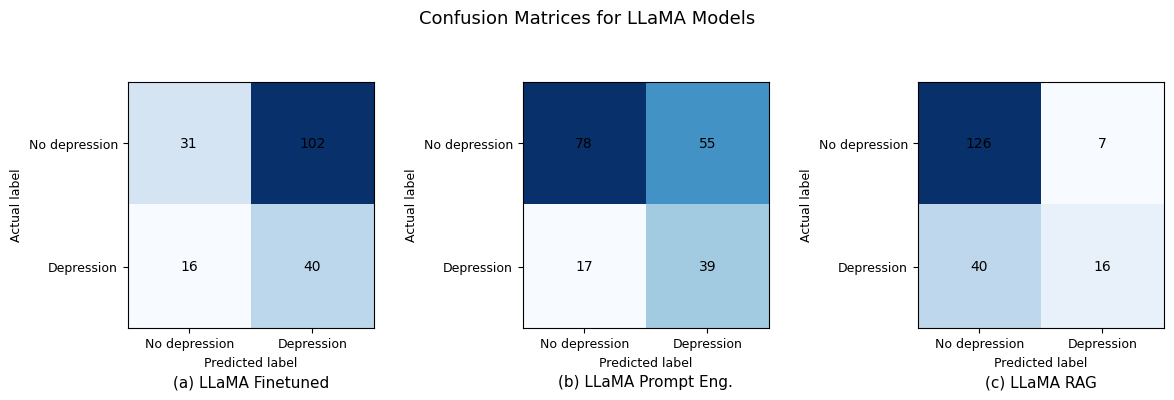

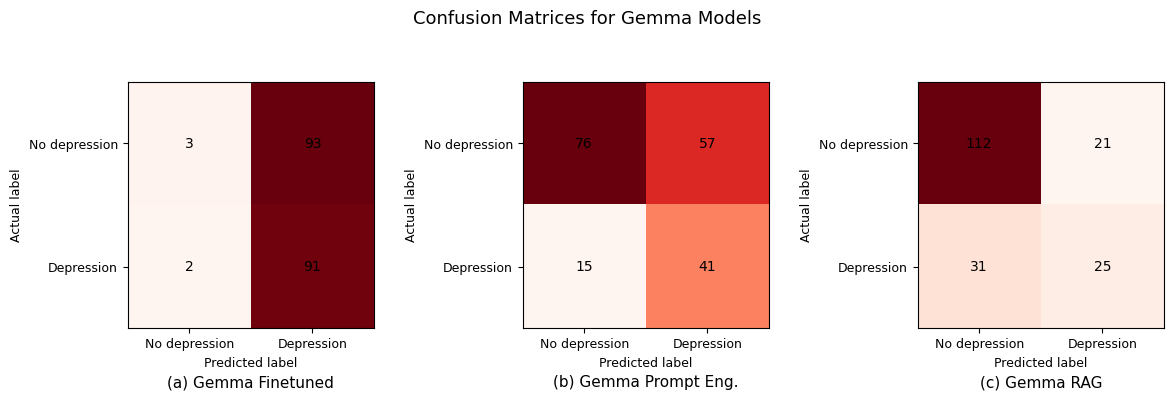

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Confusion matrices (TN, FP, FN, TP)
# -----------------------------
# LLaMA models
llama_finetuned = np.array([[31, 102],
                            [16,  40]])   # [[TN, FP], [FN, TP]]

llama_prompt = np.array([[78, 55],
                         [17, 39]])

llama_rag = np.array([[126,  7],
                      [ 40, 16]])

# Gemma models
gemma_finetuned = np.array([[ 3, 93],
                            [ 2, 91]])

# TODO: fill these with the actual numbers once you read them off the image
# gemma_prompt = np.array([[TN, FP],
#                          [FN, TP]])
gemma_prompt = np.array([[76, 57],
                         [15, 41]])  # placeholder so code runs; replace with real values

gemma_rag = np.array([[112, 21],
                      [ 31, 25]])


def plot_confusion_row(matrices, titles, panel_labels, fig_title, cmap, filename=None):
    """
    matrices: list of 2x2 numpy arrays
    titles: list of short model titles
    panel_labels: list like ['(a)', '(b)', '(c)']
    fig_title: overall figure title
    cmap: matplotlib colormap, e.g. 'Blues' or 'Reds'
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, cm, title, plabel in zip(axes, matrices, titles, panel_labels):
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

        # Axis tick labels – short & horizontal
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['No depression', 'Depression'], fontsize=9)
        ax.set_yticklabels(['No depression', 'Depression'], fontsize=9)

        # Common axis labels
        ax.set_xlabel('Predicted label', fontsize=9)
        ax.set_ylabel('Actual label', fontsize=9)

        # Annotate cell values
        for i in range(2):
            for j in range(2):
                ax.text(
                    j, i, int(cm[i, j]),
                    ha='center', va='center',
                    fontsize=10, color='black'
                )

        ax.text(
          0.5, -0.22,
          f"{plabel} {title}",
          transform=ax.transAxes,
          ha='center',
          va='center',
          fontsize=11
      )

    fig.suptitle(fig_title, fontsize=13)
    fig.tight_layout(rect=[0, 0.02, 1, 0.92])

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


# -----------------------------
# Plot LLaMA confusion matrices in one row (blue shades)
# -----------------------------
llama_mats = [llama_finetuned, llama_prompt, llama_rag]
llama_titles = ['LLaMA Finetuned', 'LLaMA Prompt Eng.', 'LLaMA RAG']
llama_panels = ['(a)', '(b)', '(c)']

plot_confusion_row(
    matrices=llama_mats,
    titles=llama_titles,
    panel_labels=llama_panels,
    fig_title='Confusion Matrices for LLaMA Models',
    cmap='Blues',
    filename='llama_confusion_matrices.png'
)

# -----------------------------
# Plot Gemma confusion matrices in one row (red shades)
# -----------------------------
gemma_mats = [gemma_finetuned, gemma_prompt, gemma_rag]
gemma_titles = ['Gemma Finetuned', 'Gemma Prompt Eng.', 'Gemma RAG']
gemma_panels = ['(a)', '(b)', '(c)']

plot_confusion_row(
    matrices=gemma_mats,
    titles=gemma_titles,
    panel_labels=gemma_panels,
    fig_title='Confusion Matrices for Gemma Models',
    cmap='Reds',
    filename='gemma_confusion_matrices.png'
)


## Plotting all the Accuracies

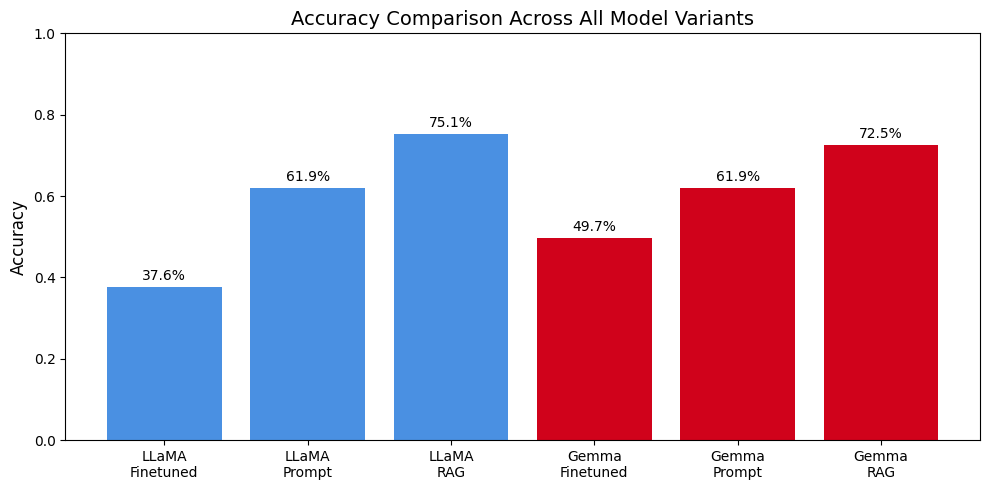

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values for all 6 models
accuracies = {
    'LLaMA\nFinetuned': 0.3757,
    'LLaMA\nPrompt':    0.6190,
    'LLaMA\nRAG':       0.7513,
    'Gemma\nFinetuned': 0.4970,
    'Gemma\nPrompt':    0.6190,
    'Gemma\nRAG':       0.7249
}

# Extract names and values
model_names = list(accuracies.keys())   # now contains \n for wrapping
acc_values  = list(accuracies.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, acc_values,
               color=['#4A90E2','#4A90E2','#4A90E2',
                      '#D0021B','#D0021B','#D0021B'])

# Add accuracy labels on top
for bar, acc in zip(bars, acc_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f"{acc*100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.0)

# Keep labels horizontal
plt.xticks(rotation=0, fontsize=10)

plt.title("Accuracy Comparison Across All Model Variants", fontsize=14)
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
